# 1. Required packages

## For the interactivity I'm using _plotly_ library and _Jupyter Widgets_. 
It allows to prototype dashboard in some way. Hence, for correct execution of the current notebook one has to install the following packages: 
   - [plotly](https://plot.ly/python/) + [cufflinks](https://plot.ly/ipython-notebooks/cufflinks/)
   - [ipywidgets](https://github.com/jupyter-widgets/ipywidgets)

and activate the required extensions for Jupyter. Feel free to do it manually or run the following script.

In [1]:
# %%bash
# pip install plotly
# pip install cufflinks
# pip install ipywidgets
# jupyter nbextension install --py --sys-prefix widgetsnbextension
# jupyter nbextension install --py --sys-prefix plotlywidget
# jupyter nbextension enable --py --sys-prefix widgetsnbextension
# jupyter nbextension enable --py --sys-prefix plotlywidget

To validate the correct installation and activation of the required packages please execute:

In [2]:
%%bash 
jupyter nbextension list

Known nbextensions:
  config dir: /anaconda3/envs/DL/etc/jupyter/nbconfig
    notebook section
      plotlywidget/extension  enabled 
      jupyter-js-widgets/extension  enabled 


      - Validating: OK
      - Validating: OK


# 2. Data I/O
We assume that one has already obtained the embeddings for the researched financial statement network. 

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from NetEmbs import *

MODE = "SimulatedData"
DB_PATH = "Simulation/FSN_Data_5k.db"
# CONFIG.ROOT_FOLDER = "UvA/GoogleColab/Optimal 5k/"
CONFIG.ROOT_FOLDER = "UvA/Refactoring/"
IMAGE_FOLDER = "img/MetricExperiments"
create_folder(IMAGE_FOLDER)
LIMIT = None

#  ---------- CONFIG Setting HERE ------------
# .1 Sampling parameters
CONFIG.STRATEGY = "MetaDiff"
CONFIG.PRESSURE = 10
CONFIG.WINDOW_SIZE = 2
CONFIG.WALKS_PER_NODE = 30
CONFIG.WALKS_LENGTH = 10
# .2 TF parameters
CONFIG.STEPS = 50000
CONFIG.EMBD_SIZE = 8
CONFIG.LOSS_FUNCTION = "NegativeSampling"  # or "NCE"
CONFIG.BATCH_SIZE = 256
CONFIG.NEGATIVE_SAMPLES = 512

try:
    updateCONFIG_4experiments(False)
except TypeError as e:
    logging.getLogger(CONFIG.MAIN_LOGGER).critical(e)
    raise TypeError("Critical error during CONFIG update. Stop execution!")
except IOError as e:
    logging.getLogger(CONFIG.MAIN_LOGGER).critical(e)
    raise IOError("Critical error during CONFIG update. Stop execution!")
        
EMBS_PATH = CONFIG.WORK_FOLDER[0]+CONFIG.WORK_FOLDER[1]+CONFIG.WORK_FOLDER[2]

if MODE == "SimulatedData":
    embeddings = pd.read_pickle(EMBS_PATH+"Embeddings.pkl")
    print("Embeddings have been uploaded to memory!")
    # 1. Upload JournaEntries into memory
    d = upload_data(DB_PATH, limit=LIMIT)
    journal_truth = upload_journal_entries(DB_PATH)[["ID", "GroundTruth", "Time"]]
    # 2. Data pre-processing
    d = data_preprocessing(d)

if MODE == "RealData":
    import extras
    import analysis
    EMBS_PATH = "model/15108_2017_versionMetaDiff_directionCOMBI_walks31_pressure30_window3/TFsteps100000batch64_emb32/"
    embeddings = pd.read_pickle(EMBS_PATH+"cache/Embeddings.pkl")
    # //////// TODO UPLOAD your data HERE \\\\\\\\\\
    # d =
    # //////// END  \\\\\\\\\\
    d = d.rename(index=str, columns={"transactionID": "ID", "accountID": "FA_Name", "BR": "GroundTruth", "amount": "Value"})
    d = data_preprocessing(d)
    journal_truth = d.groupby("ID", as_index=False).agg({"GroundTruth": "first"})
print("Shape of uploaded Dataset is ", d.shape)
embeddings = embeddings.merge(journal_truth, on="ID")
print("Clustering the obtained embeddings!")
embeddings = cl_Agglomerative(embeddings, 11)

Config file has been updated!
Embeddings have been uploaded to memory!
Shape of uploaded Dataset is  (29239, 9)
Clustering the obtained embeddings!


# The number of samples per each GroundTruth

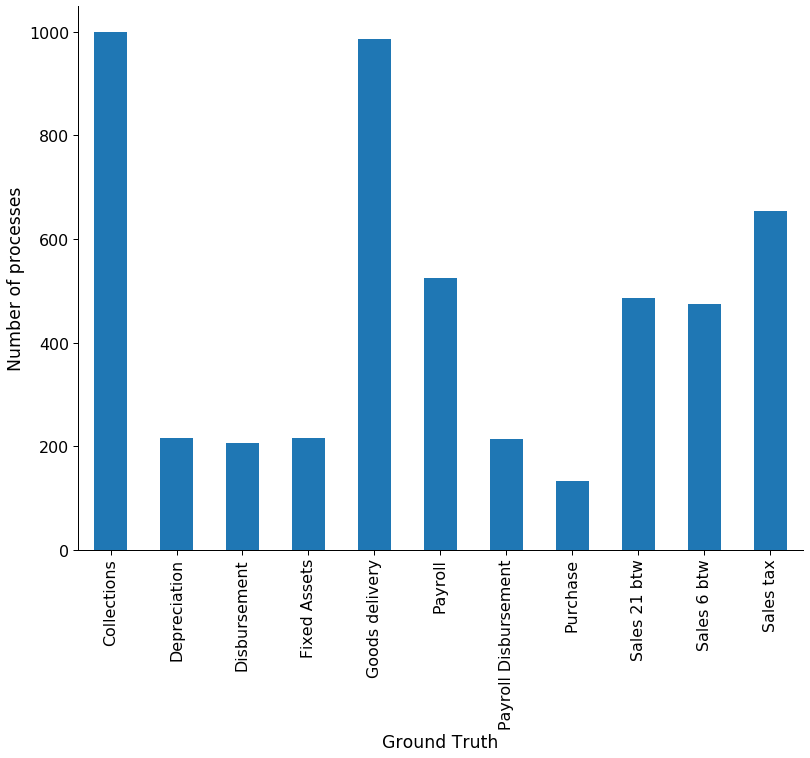

In [5]:
draw.GroundTruth_histogram(embeddings)

# 3. Interactive visualization

In [6]:
dashboard(embeddings, d)

    'data': [{'customdata': [27, 34, 38, ..., 5031, 5034, 5035]…

# Time-Series modeling

In [7]:
labels_to_titles = embeddings.groupby("label").GroundTruth.agg(pd.Series.mode).to_dict()
labels_to_titles

{0: 'Collections',
 1: 'Goods delivery',
 2: 'Sales 6 btw',
 3: 'Sales tax',
 4: 'Payroll',
 5: 'Disbursement',
 6: 'Depreciation',
 7: 'Purchase',
 8: 'Payroll Disbursement',
 9: 'Fixed Assets',
 10: 'Sales 21 btw'}

In [8]:
# TODO helper uploader for obtain Time column. 
if MODE=="SimulatedData":
    df_all = d.drop(["Signature", "Name"], axis=1)
    print(f"Shape of supported info is {df_all.shape}, shape of embs DataFrame is {embeddings.shape}")
    df_all = df_all.merge(embeddings, on="ID")
    print(f"After merge the shape is {df_all.shape}")
    df_all = df_all.groupby(["ID", "FA_Name", "flow"], as_index=False).aggregate({"amount": lambda x: np.sum(x), 
                                "Time": "first",
                              "GroundTruth": "first",
                              "label": "first",
                              "x": "first",
                              "y": "first"}) \
                        .sort_values("Time", ascending=True)
if MODE=="RealData":
    d["Date"] = pd.to_datetime(d["Date"],format='%Y-%m-%d')
#     df_all = d.groupby("ID", as_index=False).aggregate({"amount": lambda x: np.sum(x)/2.0, 
#                                "Date": "first"}).merge(embs, on="ID").sort_values("Date", ascending=True)
    df_all = d.groupby(["ID", "FA_Name", "flow"], as_index=False)\
                .aggregate({"amount": lambda x: np.sum(x), 
                            "Date": "first",
                           "accountDesc": "first"})\
                .merge(embeddings, on="ID")\
                .sort_values("Date", ascending=True)
    df_all.set_index(df_all.Date, inplace=True)
df_all.head(2)

Shape of supported info is (29239, 7), shape of embs DataFrame is (5109, 7)
After merge the shape is (29239, 13)


,ID,FA_Name,flow,amount,Time,GroundTruth,label,x,y
0,7,FixedAssets,inflow,52.184404,0.67896,Fixed Assets,9,25.274429,-51.699635
1,7,NoisyLeftFA_kbfq,outflow,0.021187,0.67896,Fixed Assets,9,25.274429,-51.699635


## Add DateTimeIndex to simulated data

In [9]:
if MODE=="SimulatedData":
    df_all = addDateTimeIndex(df_all)

# Tax plausible relationship

    Credit-debit model (CD) which uses only the in- and outflow but no process information
    Expert-Based model which uses in the experiment below GroundTruth
    Predicted labels model which uses the predicted labels as Processes information

Correlation for given query and given shifts (0, 0) is           0.6286277038441134


Correlation for given query and given shifts (0, 0) is           0.8173094111508721


Correlation for given query and given shifts (0, 0) is           0.9025550010896275


Correlation for given query and given shifts (0, 0) is           0.9485087812596132


Correlation for given query and given shifts (0, 0) is           0.9025550010896275


Correlation for given query and given shifts (0, 0) is           0.9485087812596132


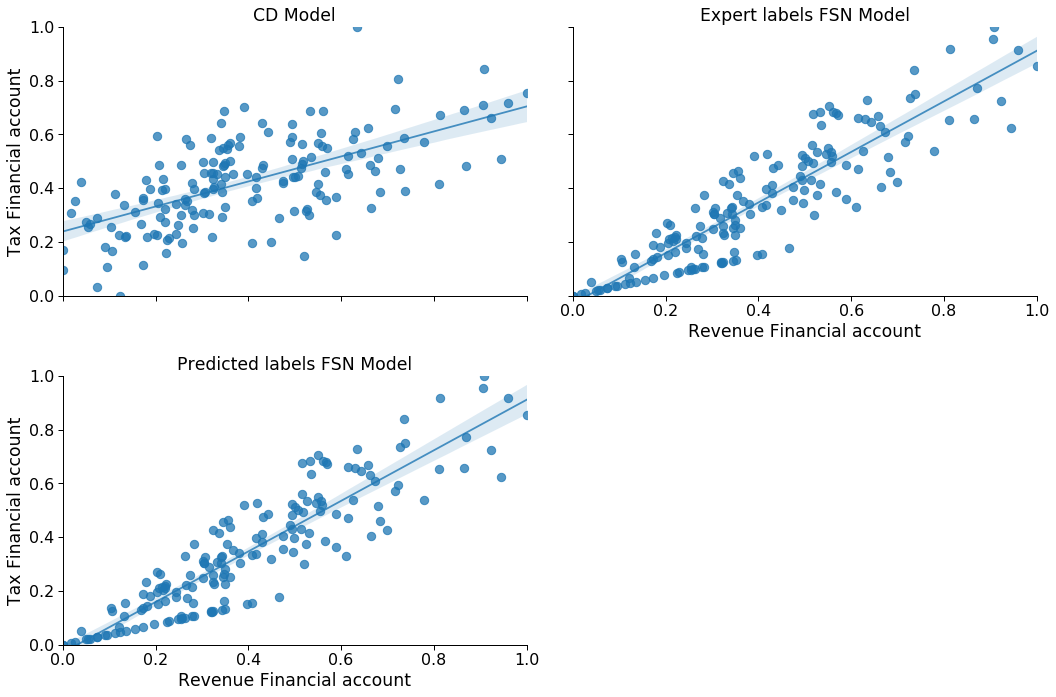

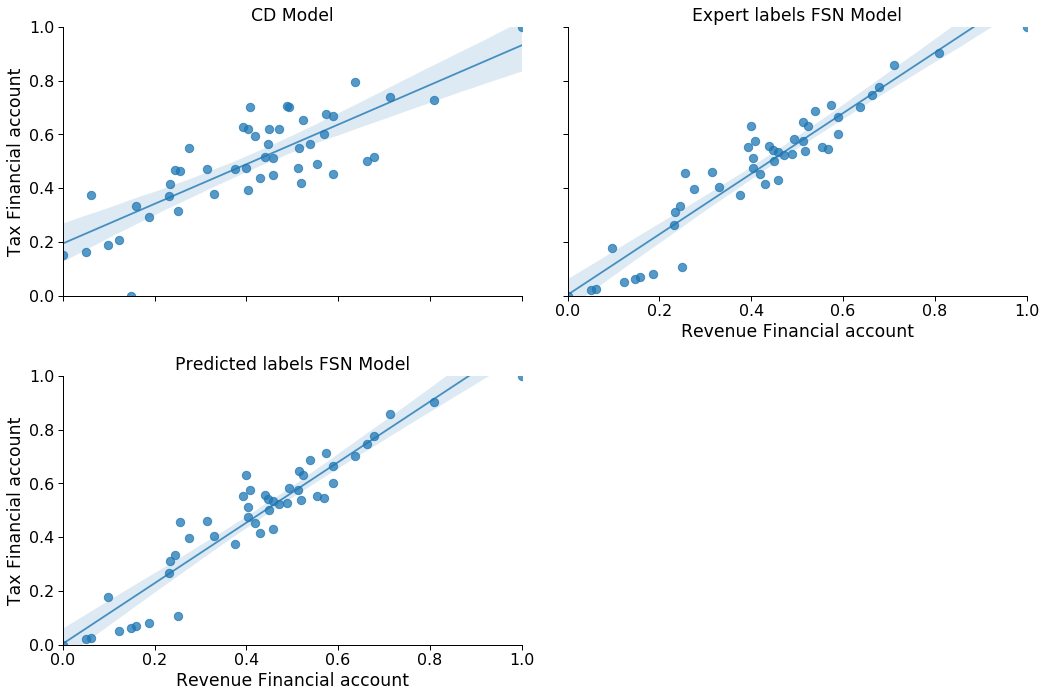

In [10]:
from NetEmbs.utils.modelling.extract_signals import extract_signals
from NetEmbs.utils.modelling.evaluation import evaluate_model
Relationship_name = "TaxRevenue"
TAX_REVENUE_DF = pd.DataFrame() # Empty DataFrame to store results
# /////////// CD Model query \\\\\\\\\\\\\
CURENT_QUERY = [{"select": ["ALL"], 
                              "_with": {"FA_Name": "Revenue"}}, 
                                {"select": ["ALL"], "_with": {"FA_Name": "Tax"}}]
for agg_period in ["2D", "W"]:
    cur_result = extract_signals(df_all, query=CURENT_QUERY, 
                                 on="label", agg_period=agg_period, 
                title=f"{IMAGE_FOLDER}/CD_Model_{Relationship_name}_{agg_period}_")
    TAX_REVENUE_DF = TAX_REVENUE_DF.append(cur_result.assign(Model="CD Model", agg_period=agg_period))
    
# Repeat the same for expert labels
# ///////// Expert Model query \\\\\\\\\\\\\\
CURENT_QUERY = [{"select": ["Sales 21 btw", "Sales 6 btw"], 
                              "_with": {"FA_Name": "Revenue"}}, 
                                {"select": ["Sales 21 btw", "Sales 6 btw"], "_with": {"FA_Name": "Tax"}}]
for agg_period in ["2D", "W"]:
    cur_result = extract_signals(df_all, query=CURENT_QUERY, 
                                 on="GroundTruth", agg_period=agg_period, 
                title=f"{IMAGE_FOLDER}/expertFSN_{Relationship_name}_{agg_period}_")
    TAX_REVENUE_DF = TAX_REVENUE_DF.append(cur_result.assign(Model="Expert labels FSN Model", agg_period=agg_period))
    
# And predicted labels
# CD Model query
CURENT_QUERY = [{"select": [2, 10], 
                              "_with": {"FA_Name": "Revenue"}}, 
                                {"select": [2, 10], "_with":  {"FA_Name": "Tax"}}]
for agg_period in ["2D", "W"]:
    cur_result = extract_signals(df_all, query=CURENT_QUERY, 
                                 on="label", agg_period=agg_period, 
                title=f"{IMAGE_FOLDER}/aFSN_{Relationship_name}_{agg_period}_")
    TAX_REVENUE_DF = TAX_REVENUE_DF.append(cur_result.assign(Model="Predicted labels FSN Model", agg_period=agg_period))
    
# Store scores to file
TAX_REVENUE_DF.groupby(["Model", "agg_period"]).apply(evaluate_model).to_excel(f"{IMAGE_FOLDER}/Scores_for_{Relationship_name}.xlsx")

# Plot regression, Do not worry, I scaled the data here to unit interval. Update Axis labels according to your data.
for name, group in TAX_REVENUE_DF.groupby("agg_period"):
    draw.regression_plot(group, save=True, filename=f"{IMAGE_FOLDER}/{Relationship_name}_{name}", labels=["Revenue Financial account", "Tax Financial account"], context="paper_full")

# Trade receivables plausible relationship

Correlation for given query and given shifts (0, -2) is           0.3558146040640146


Correlation for given query and given shifts (0, -2) is           0.7760341152227572


Correlation for given query and given shifts (0, -2) is           0.3558146040640146


Correlation for given query and given shifts (0, -2) is           0.7760341152227572


Correlation for given query and given shifts (0, -2) is           0.3558146040640146


Correlation for given query and given shifts (0, -2) is           0.7760341152227572


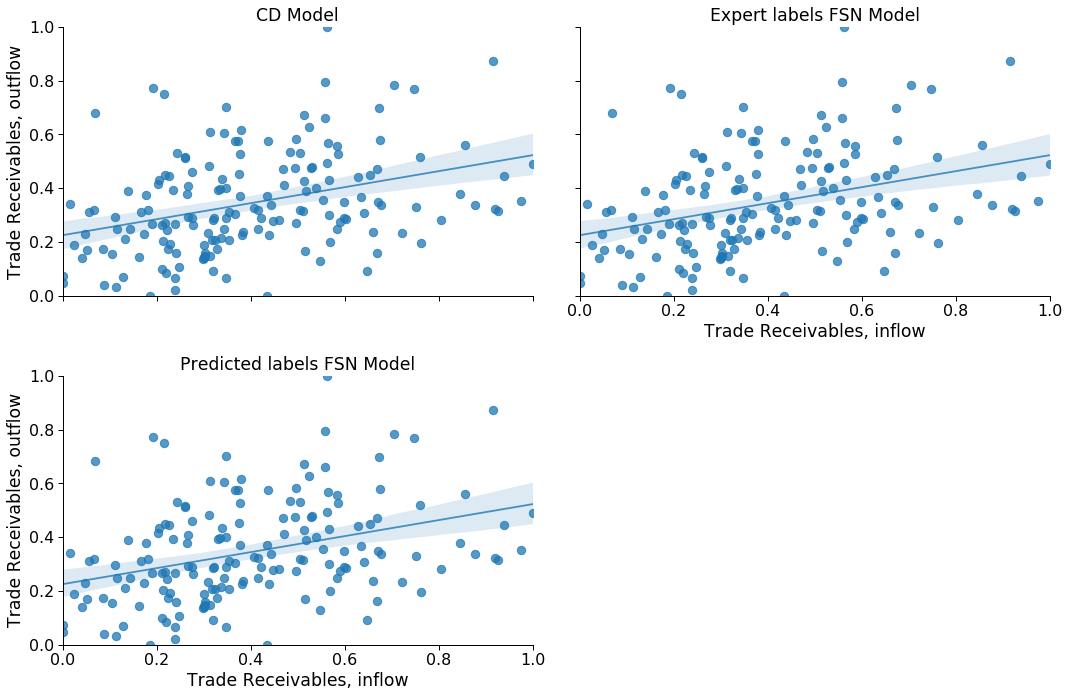

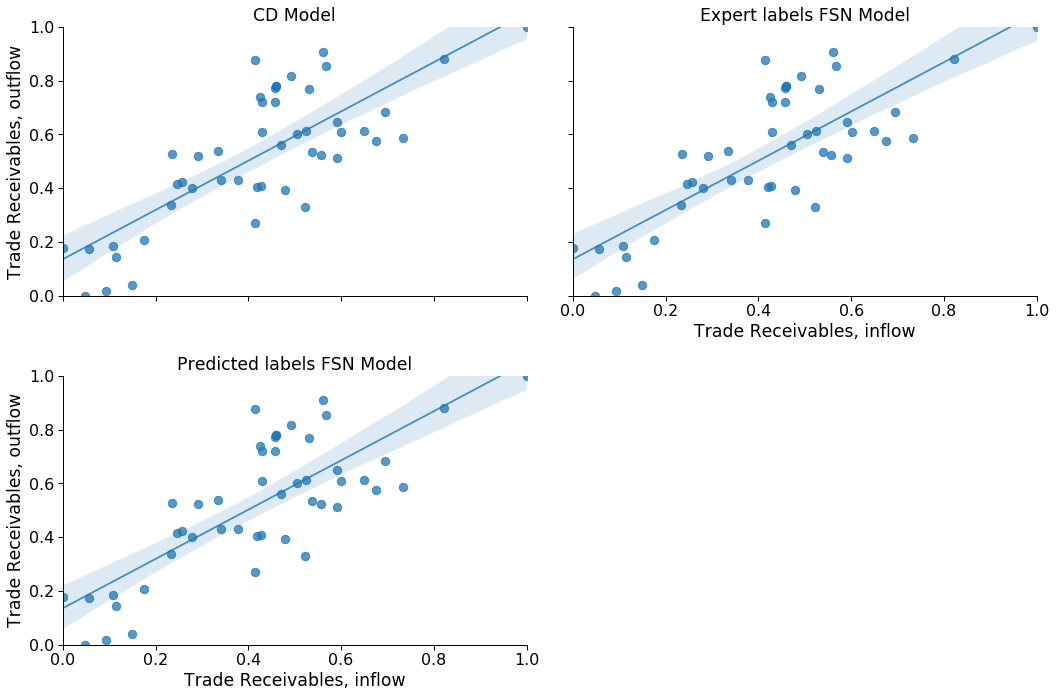

In [11]:
from NetEmbs.utils.modelling.extract_signals import extract_signals
from NetEmbs.utils.modelling.evaluation import evaluate_model
Relationship_name = "TradeReceivables"
TR_DF = pd.DataFrame() # Empty DataFrame to store results
# /////////// CD Model query \\\\\\\\\\\\\
CURENT_QUERY = [{"select": ["ALL"], 
                              "_with": {"FA_Name": "TradeReceivables", "flow": "inflow"}}, 
                                {"select": ["ALL"], "_with": {"FA_Name": "TradeReceivables", "flow": "outflow"}}]
for agg_period in ["2D", "W"]:
    cur_result = extract_signals(df_all, shift=(0, -2), query=CURENT_QUERY, 
                                 on="label", agg_period=agg_period, 
                title=f"{IMAGE_FOLDER}/CD_Model_{Relationship_name}_{agg_period}_")
    TR_DF = TR_DF.append(cur_result.assign(Model="CD Model", agg_period=agg_period))
    
# Repeat the same for expert labels
# ///////// Expert Model query \\\\\\\\\\\\\\
CURENT_QUERY = [{"select": ["Sales 21 btw", "Sales 6 btw"], 
                              "_with": {"FA_Name": "TradeReceivables", "flow": "inflow"}}, 
                                {"select": ["Collections"], "_with": {"FA_Name": "TradeReceivables", "flow": "outflow"}}]
for agg_period in ["2D", "W"]:
    cur_result = extract_signals(df_all, shift=(0, -2), query=CURENT_QUERY, 
                                 on="GroundTruth", agg_period=agg_period, 
                title=f"{IMAGE_FOLDER}/expertFSN_{Relationship_name}_{agg_period}_")
    TR_DF = TR_DF.append(cur_result.assign(Model="Expert labels FSN Model", agg_period=agg_period))
    
# And predicted labels
# CD Model query
CURENT_QUERY = [{"select": [2, 10], 
                              "_with": {"FA_Name": "TradeReceivables", "flow": "inflow"}}, 
                                {"select": [0], "_with":  {"FA_Name": "TradeReceivables", "flow": "outflow"}}]
for agg_period in ["2D", "W"]:
    cur_result = extract_signals(df_all, shift=(0, -2), query=CURENT_QUERY, 
                                 on="label", agg_period=agg_period, 
                title=f"{IMAGE_FOLDER}/aFSN_{Relationship_name}_{agg_period}_")
    TR_DF = TR_DF.append(cur_result.assign(Model="Predicted labels FSN Model", agg_period=agg_period))
    
# Store scores to file
TR_DF.groupby(["Model", "agg_period"]).apply(evaluate_model).to_excel(f"{IMAGE_FOLDER}/Scores_for_{Relationship_name}.xlsx")

# Plot regression, Do not worry, I scaled the data here to unit interval. Update Axis labels according to your data.
for name, group in TR_DF.groupby("agg_period"):
    draw.regression_plot(group, save=True, filename=f"{IMAGE_FOLDER}/{Relationship_name}_{name}", 
                         labels=["Trade Receivables, inflow", "Trade Receivables, outflow"], context="paper_full")

## Cash plausible relationship

Correlation for given query and given shifts (0, 0) is           -0.06452930707328693


Correlation for given query and given shifts (0, 0) is           -0.09150544283283603


Correlation for given query and given shifts (0, 0) is           0.5890402266282146


Correlation for given query and given shifts (0, 0) is           0.8701272693829565


Correlation for given query and given shifts (0, 0) is           0.5890402266282146


Correlation for given query and given shifts (0, 0) is           0.8701272693829565


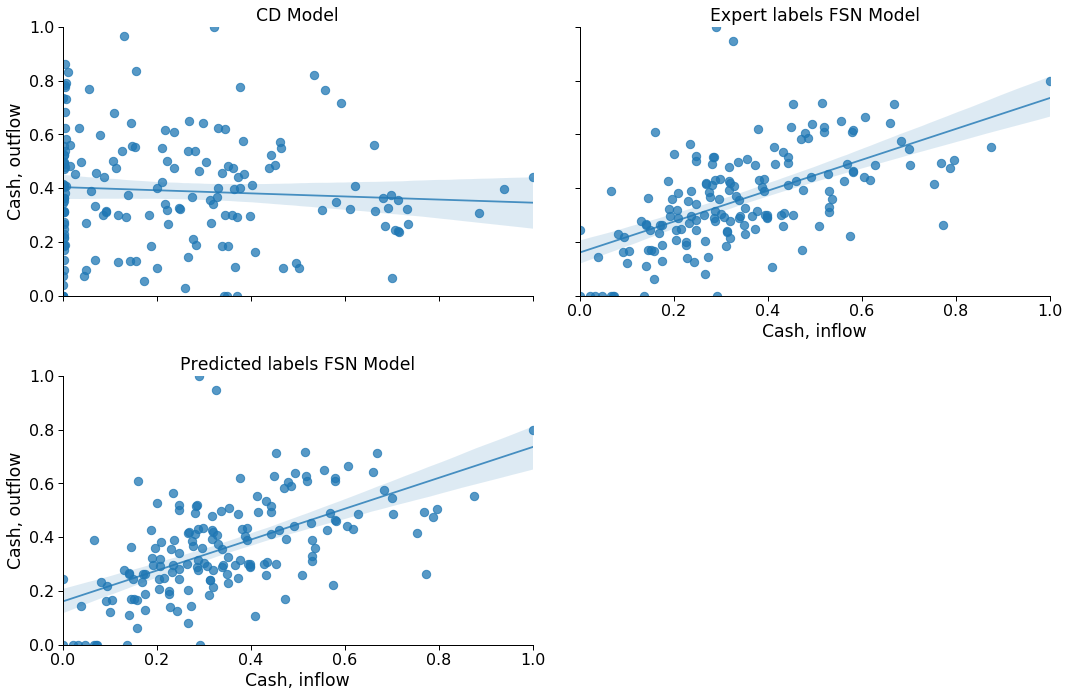

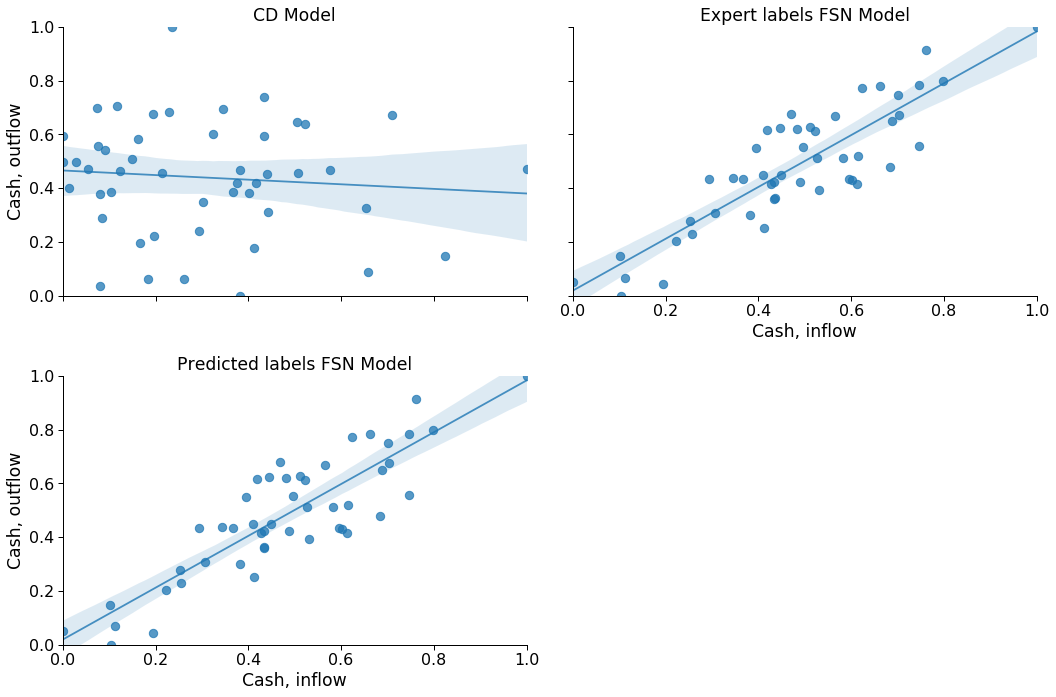

In [12]:
from NetEmbs.utils.modelling.extract_signals import extract_signals
from NetEmbs.utils.modelling.evaluation import evaluate_model
Relationship_name = "Cash"
CASH_DF = pd.DataFrame() # Empty DataFrame to store results
# /////////// CD Model query \\\\\\\\\\\\\
CURENT_QUERY = [{"select": ["ALL"], 
                              "_with": {"FA_Name": "Cash", "flow": "inflow"}}, 
                                {"select": ["ALL"], "_with": {"FA_Name": "Cash", "flow": "outflow"}}]
for agg_period in ["2D", "W"]:
    cur_result = extract_signals(df_all, shift=(0, 0), query=CURENT_QUERY, 
                                 on="label", agg_period=agg_period, 
                title=f"{IMAGE_FOLDER}/CD_Model_{Relationship_name}_{agg_period}_")
    CASH_DF = CASH_DF.append(cur_result.assign(Model="CD Model", agg_period=agg_period))
    
# Repeat the same for expert labels
# ///////// Expert Model query \\\\\\\\\\\\\\
CURENT_QUERY = [{"select": ["Collections"], 
                              "_with": {"FA_Name": "Cash", "flow": "inflow"}}, 
                                {"select": ["Sales tax"], "_with": {"FA_Name": "Cash", "flow": "outflow"}}]
for agg_period in ["2D", "W"]:
    cur_result = extract_signals(df_all, shift=(0, 0), query=CURENT_QUERY, 
                                 on="GroundTruth", agg_period=agg_period, 
                title=f"{IMAGE_FOLDER}/expertFSN_{Relationship_name}_{agg_period}_")
    CASH_DF = CASH_DF.append(cur_result.assign(Model="Expert labels FSN Model", agg_period=agg_period))
    
# And predicted labels
# CD Model query
CURENT_QUERY = [{"select": [0], 
                              "_with": {"FA_Name": "Cash", "flow": "inflow"}}, 
                                {"select": [3], "_with":  {"FA_Name": "Cash", "flow": "outflow"}}]
for agg_period in ["2D", "W"]:
    cur_result = extract_signals(df_all, shift=(0, 0), query=CURENT_QUERY, 
                                 on="label", agg_period=agg_period, 
                title=f"{IMAGE_FOLDER}/aFSN_{Relationship_name}_{agg_period}_")
    CASH_DF = CASH_DF.append(cur_result.assign(Model="Predicted labels FSN Model", agg_period=agg_period))
    
# Store scores to file
CASH_DF.groupby(["Model", "agg_period"]).apply(evaluate_model).to_excel(f"{IMAGE_FOLDER}/Scores_for_{Relationship_name}.xlsx")

# Plot regression, Do not worry, I scaled the data here to unit interval. Update Axis labels according to your data.
for name, group in CASH_DF.groupby("agg_period"):
    draw.regression_plot(group, save=True, filename=f"{IMAGE_FOLDER}/{Relationship_name}_{name}", 
                         labels=["Cash, inflow", "Cash, outflow"], context="paper_full")

## Correlation matrix

In [13]:
correlation_heatmap(df_all, on="label", agg_period="D", interactive=True)
correlation_heatmap(df_all, on="GroundTruth", agg_period="D", interactive=True)